# Question Filtering Pipeline

EDIT corpus_id, set this to your corpus as named in /data/

In [66]:
corpus_id = 'wikitexts'

import pandas as pd

questions_df = pd.read_csv('../data/questions_df.csv')
questions_df = questions_df[questions_df['corpus_id'] == corpus_id]

In [67]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

def get_sim(target, references):
    response = client.embeddings.create(
        input=[target]+references,
        model="text-embedding-3-large"
    )
    cosine_similarities = []
    nparray1 = np.array(response.data[0].embedding)

    full_sim = []
    for i in range(1, len(response.data)):
        nparray2 = np.array(response.data[i].embedding)
        cosine_similarity = np.dot(nparray1, nparray2) / (np.linalg.norm(nparray1) * np.linalg.norm(nparray2))
        # full_sim.append((target, references[i-1], cosine_similarity))
        full_sim.append(cosine_similarity)
    # return np.mean(cosine_similarities)
    
    return full_sim

In [68]:
import json

# Apply json.loads directly to the 'references' column
questions_df['references'] = questions_df['references'].apply(json.loads)


In [69]:
# Define the function to edit each row
def edit_row(row):
    question = row['question']
    references = [ref['content'] for ref in row['references']]
    similarity_scores = get_sim(question, references)
    worst_ref_score = min(similarity_scores)
    row['worst_ref_score'] = worst_ref_score
    return row

# Apply the function to each row
questions_df = questions_df.apply(edit_row, axis=1)


Mean:  0.511518831010476
Standard Deviation: 0.14649123223282734
Median: 0.49125707610954383
Top 75%: 0.6108830833626763
Bottom 25%: 0.4045355102769339


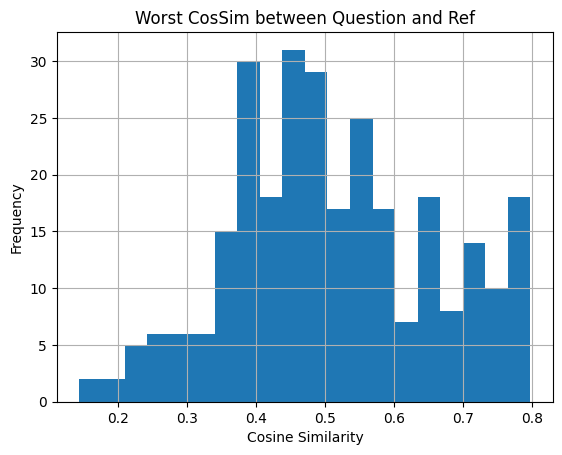

In [70]:
import matplotlib.pyplot as plt

cosine_scores = questions_df['worst_ref_score'].values
print("Mean: ", cosine_scores.mean())
print("Standard Deviation:", np.std(cosine_scores))
print("Median:", np.median(cosine_scores))
print("Top 75%:", np.percentile(cosine_scores, 75))
print("Bottom 25%:", np.percentile(cosine_scores, 25))

plt.hist(cosine_scores, bins=20)
plt.title('Worst CosSim between Question and Ref')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

EDIT threshold, set this to some value and see text given below. Change it until you're happy with outputs.

In [71]:
# Test threshold:
threshold = 0.36

print("Number of questions with worst CosSim below threshold:", len(questions_df[questions_df['worst_ref_score'] < threshold]))
# Remove questions with worst CosSim below threshold
filtered_questions_df = questions_df[questions_df['worst_ref_score'] >= threshold]

# Calculate the percentage of questions removed
percentage_removed = (len(questions_df) - len(filtered_questions_df)) / len(questions_df) * 100

# Print the results
print("Percentage of questions removed:", percentage_removed)
print("Number of questions left:", len(filtered_questions_df))

# Add a new column to the dataframe for the absolute difference between the worst_ref_score and the threshold
questions_df['score_diff'] = abs(questions_df['worst_ref_score'] - threshold)

# Print out the 3 questions closest to the threshold from below and their references
print("3 questions closest to the threshold from below and their references:")
for _, row in questions_df[questions_df['worst_ref_score'] < threshold].nsmallest(3, 'score_diff').iterrows():
    print("Question:", row['question'])
    print("References:", row['references'])
    print()

# Print out the 3 questions closest to the threshold from above and their references
print("\n3 questions closest to the threshold from above and their references:")
for _, row in questions_df[questions_df['worst_ref_score'] >= threshold].nsmallest(3, 'score_diff').iterrows():
    print("Question:", row['question'])
    print("References:", row['references'])
    print()

Number of questions with worst CosSim below threshold: 36
Percentage of questions removed: 12.676056338028168
Number of questions left: 248
3 questions closest to the threshold from below and their references:
Question: What were Governor Rector's actions in response to the unauthorized militia assembly at Little Rock?
References: [{'content': 'Governor Rector vehemently denied ordering the troops to assemble or giving any order at all in connection with the troops', 'start_index': 25672, 'end_index': 25794}, {'content': 'Faced with the fact that the military had assembled believing they were following his orders and the consensus of the citizens of Little Rock against any armed conflict between the civilian army and federal troops , Governor Rector was forced to take control of the situation ', 'start_index': 25797, 'end_index': 26073}, {'content': 'On February 6 , he sent a formal demand for surrender of the arsenal to Captain Totten , ', 'start_index': 26075, 'end_index': 26164}]

Q

# Make Reference Cut

In [72]:
questions_df = questions_df[questions_df['worst_ref_score'] >= threshold]
questions_df = questions_df.drop(columns=['score_diff', 'worst_ref_score'])

In [74]:
print(len(questions_df))
# Remove duplicates from the questions dataframe
questions_df.drop_duplicates(subset='question', keep='first', inplace=True)
print(len(questions_df))

248
244


In [75]:
questions = questions_df['question'].tolist()

In [76]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

response = client.embeddings.create(
    input=questions,
    model="text-embedding-3-large"
)

0.8541809863055387


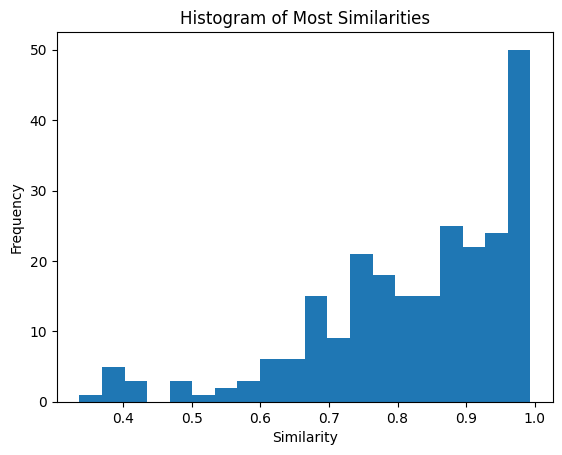

In [77]:
embeddings_matrix = np.array([data.embedding for data in response.data])

dot_product_matrix = np.dot(embeddings_matrix, embeddings_matrix.T)

# Create a list of tuples containing the index pairs and their similarity
similarity_pairs = [(i, j, dot_product_matrix[i][j]) for i in range(len(dot_product_matrix)) for j in range(i+1, len(dot_product_matrix))]

# Sort the list of tuples based on the similarity in descending order
similarity_pairs.sort(key=lambda x: x[2], reverse=True)

similarity_scores = np.array([x[2] for x in similarity_pairs])

most_similars = (dot_product_matrix - np.eye(dot_product_matrix.shape[0])).max(axis=1)

print(np.median(most_similars))

import matplotlib.pyplot as plt

# Assuming most_similars is a numpy array
plt.hist(most_similars, bins=20)
plt.title('Histogram of Most Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

EDIT threshold, then check output below. Keep changing until you're happy with outputs.

In [78]:
threshold = 0.78

def filter_vectors(sim_matrix, threshold):
    n = sim_matrix.shape[0]  # Number of vectors
    remaining = np.ones(n, dtype=bool)  # Initialize all vectors as remaining

    for i in range(n):
        if remaining[i] == 1:  # Only check for vectors that are still remaining
            for j in range(i+1, n):
                if remaining[j] == 1 and sim_matrix[i, j] > threshold:
                    remaining[j] = 0  # Remove vector j because it's too similar to vector i
    
    return remaining

rows_to_keep = filter_vectors(dot_product_matrix, threshold)

# Find the index of the threshold in the similarity_scores array
# Since threshold is a decimal, we use np.isclose to find the index
# As per the followup instructions, we find the one with the smallest distance
threshold_index = np.argmin(np.abs(similarity_scores - threshold))

print(f"Similarity Threshold: {threshold}")

print(f"Number of questions cut: {len(rows_to_keep) - rows_to_keep.sum()}")
print(f"Number of questions left: {rows_to_keep.sum()}")

print("Questions about threshold:")
for i in range(threshold_index-4, threshold_index+6):
    first_index, second_index, sim = similarity_pairs[i]
    print(questions[first_index])
    print(questions[second_index])
    print(sim)
    print("------\n")
    if i == threshold_index:
        print("---Threshold---")

Similarity Threshold: 0.78
Number of questions cut: 106
Number of questions left: 138
Questions about threshold:
What were the provisions agreed upon by Captain Totten for the surrender of the Little Rock Arsenal in 1861?
What conditions did Governor Rector impose for the surrender of the Little Rock Arsenal?
0.7830277636356879
------

What additional content was released for Valkyria Chronicles III after its initial launch?
What adaptations were made for Valkyria Chronicles 3 following its release?
0.7827536198271905
------

What roles has the Tower Building of the Little Rock Arsenal served through history?
What museums have been housed in the Tower Building of the Little Rock Arsenal?
0.7824644235531443
------

What measures did Captain James Totten take in response to the anticipated seizure of the Little Rock Arsenal in 1861?
What measures did Governor Rector take when faced with the assembly of militia at the Little Rock Arsenal in early 1861?
0.7809528096920098
------

What impr

# Make the cut

In [80]:
questions_df = questions_df[rows_to_keep]

# Save edited questions

In [84]:

questions_df['references'] = questions_df['references'].apply(json.dumps)

full_questions_df = pd.read_csv('../data/questions_df.csv')
full_questions_df = full_questions_df[full_questions_df['corpus_id'] != corpus_id]
# edited_rows_df = pd.read_csv('../data/edited_rows_df.csv')
full_questions_df = pd.concat([full_questions_df, questions_df], ignore_index=True)
full_questions_df.to_csv('../data/questions_df.csv', index=False)


In [269]:
union_questions = full_questions_df[full_questions_df['corpus_id'] == 'state_of_the_union']


In [271]:
union_questions = union_questions.drop(columns=['worst_ref_score'])
union_questions['fixed'] = False
union_questions

,question,references,corpus_id,fixed
0,What significant regulatory changes and propos...,[{'content': 'My administration announced we’r...,state_of_the_union,False
1,What reasons did President Biden give for the ...,"[{'content': 'But unfortunately, politics have...",state_of_the_union,False
2,What were the cases discussed by President Bid...,[{'content': 'Fourteen months ago — fourteen m...,state_of_the_union,False
3,How many people are no longer denied health in...,[{'content': 'Over 100 million of you can no l...,state_of_the_union,False
4,"Which country is Putin invading, causing chaos...","[{'content': 'Overseas, Putin of Russia is on ...",state_of_the_union,False
...,...,...,...,...
92,What did President Biden emphasize about defen...,[{'content': 'tood strong and democracy prevai...,state_of_the_union,False
93,What specific actions has President Biden take...,[{'content': 'containing the threat posed by I...,state_of_the_union,False
94,What are President Biden's stated intentions r...,[{'content': 'If anyone here tries to cut Soci...,state_of_the_union,False
95,What actions has President Biden described for...,"[{'content': ""Creating stability in the Middle...",state_of_the_union,False


In [272]:
with open('../data/state_of_the_union.md', 'r') as file:
    corpus = file.read()

In [100]:
full_questions_df['references'].iloc[1]

"[{'content': 'But unfortunately, politics have derailed this bill so far.', 'start_index': 29521, 'end_index': 29580}, {'content': 'I’m told my predecessor called members of Congress in the Senate to demand they block the bill. He feels political win — he viewed it as a — it would be a political win for me and a political loser for him.', 'start_index': 29582, 'end_index': 29788}]"

In [374]:
target = "Creating stability in the Middle East also means containing the threat posed by Iran. That’s why I built a coalition of more than a dozen countries to defend international shipping and freedom of navigation in the Red Sea."
start_index = corpus.find(target)
end_index = start_index + len(target)
print(corpus.find(target))
print(corpus.find(target) + len(target))

41872
42094


In [377]:
target2 = "I’ve ordered strikes to degrade the Houthi capability and defend U.S. forces in the region."
start_index2 = corpus.find(target2)
end_index2 = start_index2 + len(target2)
print(corpus.find(target2))

42096


In [376]:
corpus[start_index2-100:end_index2+200]

'to defend international shipping and freedom of navigation in the Red Sea.\n\nI’ve ordered strikes to degrade the Houthi capability and defend U.S. forces in the region.\n\nAs Commander-in-Chief, I will not hesitate to direct further measures to protect our people and our military personnel.\n\nFor years, I’ve heard many of my Republ'

In [373]:
print(corpus[corpus.find(target)-100:corpus.find(target)+400])

and all of its neighbors — including Saudi Arabia, with whom I’m talking.

Creating stability in the Middle East also means containing the threat posed by Iran. That’s why I built a coalition of more than a dozen countries to defend international shipping and freedom of navigation in the Red Sea.

I’ve ordered strikes to degrade the Houthi capability and defend U.S. forces in the region.

As Commander-in-Chief, I will not hesitate to direct further measures to protect our people and our military


In [382]:
import re

def extract_text(row):
    # print(row)


    if row['fixed']:
        return row
    

    # pattern = r"'content': '(.*?)', 'start_index'"
    # text = row['references']

    # # Find all matches and convert them to integers
    # contents = [text for text in re.findall(pattern, text)]

    # if len(contents) == 0:
    #     return row

    # start_indexes = [corpus.find(content) for content in contents]

    # if -1 in start_indexes:
    #     return row

    # references = []

    # for content, start_index in zip(contents, start_indexes):
    #     end_index = start_index + len(content)

    #     references.append({'content': content, 'start_index': start_index, 'end_index': end_index})

        # print(content)
        # print(start_index)
        # print(end_index)
        # print(corpus[start_index-100:end_index+200])
        # print("------")
    
    # row['references'] = references

    # row['fixed'] = True

    # print(contents)
    
    # # print(row)
    print(row['question'])
    print(row['references'])

    print(row.name)



    if row.name == 95:
        # row['references'] = [{'content': "My lifetime has taught me to embrace freedom and democracy, a future based on core values that have defined America — honesty, decency, dignity, and equality; to respect everyone; to give everyone a fair shot; to give hate no safe harbor.", 'start_index': 44917, 'end_index': 45155},

        #                      ]
        # row['references'] = [{'content': target, 'start_index': start_index, 'end_index': end_index}]
        row['references'] = [{'content': target, 'start_index': start_index, 'end_index': end_index}, {'content': target2, 'start_index': start_index2, 'end_index': end_index2}]
        row['fixed'] = True


    return row

union_questions = union_questions.apply(extract_text, axis=1)



In [385]:
union_questions.to_csv('../data/backup_union_questions.csv')

In [381]:
union_questions = union_questions.drop(78)


# Goals:
Check wiki questions aren't offset now. 
Run metrics and send Anton results. 

In [278]:
union_questions['references'].iloc[4]

[{'content': 'Overseas, Putin of Russia is on the march, invading Ukraine and sowing chaos throughout Europe and beyond.',
  'start_index': 1039,
  'end_index': 1145}]

In [386]:
full_questions_df = pd.read_csv('../data/questions_df.csv')
full_questions_df = full_questions_df[full_questions_df['corpus_id'] != 'state_of_the_union']
full_questions_df = pd.concat([union_questions, full_questions_df], ignore_index=True)

In [390]:
full_questions_df = pd.read_csv('../data/questions_df_2.csv')


In [393]:
unique_corpus_ids = full_questions_df['corpus_id'].unique().tolist()
print(unique_corpus_ids)


['state_of_the_union', 'wikitexts']


In [394]:
full_questions_df['question'].tolist()

["What significant regulatory changes and proposals has President Biden's administration implemented or announced regarding fees and pricing transparency?",
 "What reasons did President Biden give for the failure of a particular bill's passage?",
 'What were the cases discussed by President Biden related to reproductive rights in his State of the Union Address?',
 'How many people are no longer denied health insurance due to preexisting conditions according to President Biden?',
 'Which country is Putin invading, causing chaos in Europe and beyond?',
 'When did the murder rate experience the sharpest decrease in history and how did violent crime rates change?',
 "What is the name of the new health research agency mentioned in President Biden's State of the Union Address that aims to do big things like ending cancer?",
 'According to President Biden, what is the current status of China compared to the past decade?',
 "What type of investment is being made by private companies in America